In [4]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from matplotlib import style
import time
import cv2

In [2]:
 ### Description
# There are three designated locations in the grid world indicated by R(ed),
# G(reen), and B(lue). When the episode starts, the START is 
# at a random square and the EXIT is at a random square. The START path
# must pass by the TREASURE, from the TREASURE, the path leads to the EXIT. at the EXIT the episode ends. There are 4 obstacles called WALL.
# Map:
# S(tart), P(ath), T(reasure), W(all), E(xit)
# "4x4":["SPPW",
#        "PWPP",
#        "PTPW",
#        "PWPE"]

In [ ]:
# 1 grid 4x4
# 1start 1treasure 1exit
# rewards: start, treasure, exit. 
# test 1: start, treasure:50, exit:100
# test 2: start, treasure:100, exit:50
# move: up, down, left, right

on # 0, epsilon:0.5
500 ep mean nan
on # 500, epsilon:0.4524141842502059
500 ep mean 8.762
on # 1000, epsilon:0.4093571882215585
500 ep mean 15.44
on # 1500, epsilon:0.3703979967524286
500 ep mean 19.616
on # 2000, epsilon:0.33514661509732085
500 ep mean 19.21
on # 2500, epsilon:0.30325016494694457
500 ep mean 20.498
on # 3000, epsilon:0.27438935199642484
500 ep mean 21.056
on # 3500, epsilon:0.2482752697008096
500 ep mean 21.758
on # 4000, epsilon:0.2246465072223834
500 ep mean 21.924
on # 4500, epsilon:0.20326653261934513
500 ep mean 22.62
on # 5000, epsilon:0.1839213250806981
500 ep mean 22.02
on # 5500, epsilon:0.16641723250520185
500 ep mean 21.592
on # 6000, epsilon:0.1505790329780355
500 ep mean 22.314
on # 6500, epsilon:0.13624818073988534
500 ep mean 22.778
on # 7000, epsilon:0.12328121909001953
500 ep mean 22.268
on # 7500, epsilon:0.11154834433596417
500 ep mean 23.312
on # 8000, epsilon:0.10093210641443259
500 ep mean 22.702
on # 8500, epsilon:0.09132623317628093
500 ep mea

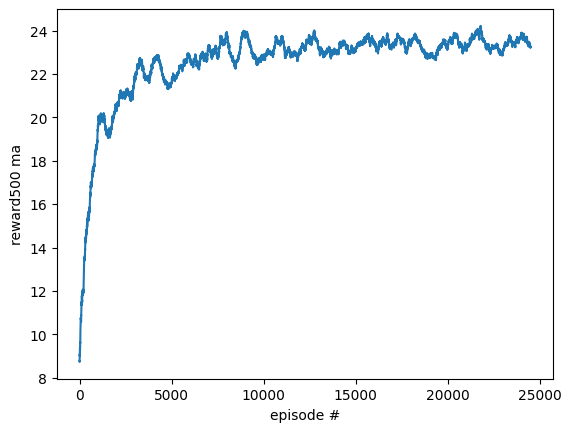

In [16]:
SIZE = 4  # 4x4 grid start, treasure, exit will be initalize at random location at 4x4 grids
HM_EPISODES = 25000
MOVE_PENALTY = 1
TREASURE_PENALTY = 25
EXIT_REWARD = 50

#enemy = treasure, exit = food

epsilon = 0.5 # will change with time
EPS_DECAY = 0.9998
SHOW_EVERY = 500

start_q_table = None #or filename

LEARNING_RATE = 0.1
DISCOUNT = 0.95

START_N = 1
EXIT_N = 2
TREASURE_N = 3

d = {1: (255, 175, 0),   # bgr color
    2: (0, 255,0),
    3: (0,0,255)}

class Blob:
    def __init__(self):
        self.x = np.random.randint(0, SIZE)
        self.y = np.random.randint(0, SIZE)
    def __str__(self):
        return f"{self.x}, {self.y}"   # Print the blob location
    def __sub__(self, other):  # define other blob and strubstract it from the other blob
        return (self.x - other.x, self.y - other.y)
    def action(self, choice):  # can only move diagonaly
        if choice == 0: #up
            self.move(x=0, y=-1)
        elif choice == 1: #down
            self.move(x=0, y=1)
        elif choice == 2: #left
            self.move(x=-1, y=0)
        elif choice == 3: #right
            self.move(x=1, y=0)
    def move(self, x=False, y=False):
        if not x:
            self.x += np.random.randint(-1,2)
        else:
            self.x += x
        if not y:
            self.y += np.random.randint(-1,2)
        else:
            self.y += y
            
        if self.x <0:
            self.x = 0
        elif self.x > SIZE-1: # size 4 but positions 0 through 3
            self.x = SIZE-1
        if self.y <0:
            self.y = 0
        elif self.y > SIZE-1: 
            self.y = SIZE-1

if start_q_table is None:
    q_table = {}
    for x1 in range(-SIZE+1, SIZE):
        for y1 in range(-SIZE+1, SIZE):
            for x2 in range(-SIZE+1, SIZE):
                for y2 in range(-SIZE+1, SIZE):
                    q_table[((x1,y1), (x2,y2))] = [np.random.uniform(-5,0) for i in range(4)]
else:
    with open(start_q_table, "rb") as f:
        q_table = pickle.load(f)

episode_rewards= []
for episode in range(HM_EPISODES):
    start = Blob()
    exit = Blob()
    treasure = Blob()
    
    if episode % SHOW_EVERY ==0:
        print(f"on # {episode}, epsilon:{epsilon}")
        print(f"{SHOW_EVERY} ep mean {np.mean(episode_rewards[-SHOW_EVERY:])}")
        show = True
    else:
        show = False
    episode_reward = 0
    for i in range(200):
        obs = (start-treasure, treasure-exit)
        if np.random.random()>epsilon:
            action = np.argmax(q_table[obs])
        else:
            action = np.random.randint(0,4)
        start.action(action)
        # enemy.move()
        if start.x == treasure.x and start.y == treasure.y:
            reward = TREASURE_PENALTY
        elif treasure.x == exit.x and treasure.y ==exit.y:
            reward = EXIT_REWARD
        else:
            reward = -MOVE_PENALTY
        new_obs = (start-treasure, treasure-exit)
        max_future_q = np.max(q_table[new_obs])
        current_q = q_table[obs][action]
        if reward == EXIT_REWARD:
            new_q = EXIT_REWARD
        elif reward == TREASURE_PENALTY:
            new_q = TREASURE_PENALTY
        else:
            new_q = (1-LEARNING_RATE)*current_q+LEARNING_RATE*(reward+DISCOUNT*max_future_q)
        q_table[obs][action] = new_q
        if show:
            env = np.zeros((SIZE, SIZE, 3), dtype=np.uint8)
            env[exit.y][exit.x] = d[EXIT_N]
            env[start.y][start.x] = d[START_N]
            env[treasure.y][treasure.x] = d[TREASURE_N]
            img = Image.fromarray(env,"RGB")
            img = img.resize((300,300))
            cv2.imshow("", np.array(img))
            if reward == EXIT_REWARD or reward == TREASURE_PENALTY:
                if cv2.waitKey(500) & 0xFF== ord("q"):
                    break
            else:
                if cv2.waitKey(1) & 0xFF== ord("q"):
                    break
        episode_reward += reward
        if reward == EXIT_REWARD or reward == TREASURE_PENALTY:
            break
    episode_rewards.append(episode_reward)
    epsilon *= EPS_DECAY

moving_avg = np.convolve(episode_rewards, np.ones((SHOW_EVERY,))/SHOW_EVERY, mode="valid")
plt.plot([i for i in range(len(moving_avg))], moving_avg)
plt.ylabel(f"reward{SHOW_EVERY} ma")
plt.xlabel("episode #")
plt.show()

# with open(f"q_table-{int(time.time())}.pickle", "wb") as f:
#     pickle.dump(q_table,f)